In [1]:
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer
from sklearn.model_selection import GridSearchCV
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn import tree
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from graphviz import Source
import plotly.graph_objects as go

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/gender-inequality-index/Gender_Inequality_Index.csv


## Data cleaning

In [2]:
df = pd.read_csv('/kaggle/input/gender-inequality-index/Gender_Inequality_Index.csv')
print(df.shape)
df.info()

(195, 11)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 195 entries, 0 to 194
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Country                195 non-null    object 
 1   Human_development      191 non-null    object 
 2   GII                    170 non-null    float64
 3   Rank                   170 non-null    float64
 4   Maternal_mortality     184 non-null    float64
 5   Adolescent_birth_rate  195 non-null    float64
 6   Seats_parliament       193 non-null    float64
 7   F_secondary_educ       177 non-null    float64
 8   M_secondary_educ       177 non-null    float64
 9   F_Labour_force         180 non-null    float64
 10  M_Labour_force         180 non-null    float64
dtypes: float64(9), object(2)
memory usage: 16.9+ KB


In [3]:
df.isnull().sum()

Country                   0
Human_development         4
GII                      25
Rank                     25
Maternal_mortality       11
Adolescent_birth_rate     0
Seats_parliament          2
F_secondary_educ         18
M_secondary_educ         18
F_Labour_force           15
M_Labour_force           15
dtype: int64

In [4]:
#Drop rank as it is redundant (same data as GII)
df = df.drop('Rank', axis = 1)
df.tail(15)

,Country,Human_development,GII,Maternal_mortality,Adolescent_birth_rate,Seats_parliament,F_secondary_educ,M_secondary_educ,F_Labour_force,M_Labour_force
180,Sierra Leone,Low,0.633,1120.0,100.9,12.3,34.7,51.5,56.1,55.9
181,Guinea,Low,0.621,576.0,114.8,16.7,7.2,19.7,62.1,62.2
182,Yemen,Low,0.820,164.0,54.4,0.3,22.4,37.5,6.0,67.6
183,Burkina Faso,Low,0.621,320.0,110.5,6.3,11.3,17.1,57.2,72.7
184,Mozambique,Low,0.537,289.0,165.8,42.4,10.8,20.2,77.7,78.9
185,Mali,Low,0.613,562.0,150.1,27.3,8.0,15.5,57.7,79.7
186,Burundi,Low,0.505,548.0,53.6,38.9,7.8,13.0,79.0,77.4
187,Central African Republic,Low,0.672,829.0,160.5,12.9,13.9,31.6,63.3,79.5
188,Niger,Low,0.611,509.0,170.5,25.9,9.2,15.2,61.7,84.3
189,Chad,Low,0.652,1140.0,138.3,32.3,7.7,24.4,46.9,69.9


array([[<AxesSubplot:title={'center':'GII'}>,
        <AxesSubplot:title={'center':'Maternal_mortality'}>,
        <AxesSubplot:title={'center':'Adolescent_birth_rate'}>],
       [<AxesSubplot:title={'center':'Seats_parliament'}>,
        <AxesSubplot:title={'center':'F_secondary_educ'}>,
        <AxesSubplot:title={'center':'M_secondary_educ'}>],
       [<AxesSubplot:title={'center':'F_Labour_force'}>,
        <AxesSubplot:title={'center':'M_Labour_force'}>, <AxesSubplot:>]],
      dtype=object)

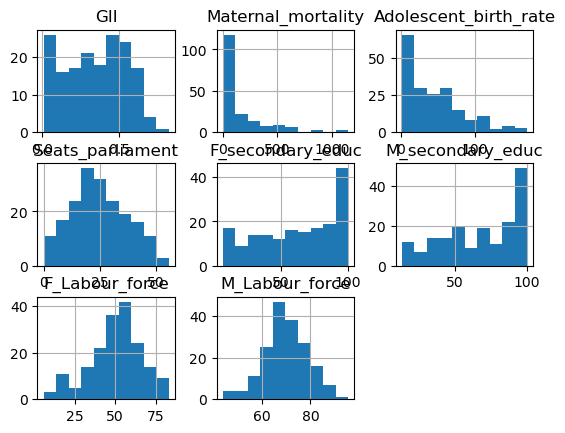

In [5]:
df.hist()

From these depictions and understanding of our variables these distributions make sense. We have high sampling of countries with lower GII (higher human development) and less countries with high GII. This seems like soething we want to consider with future data collections as we get a better distribution of countries sampled. What we are likely to see with models trained with the current data is a good prediction of low GII countries and likely poorer performance on the high GII countries.

In [6]:
#Using KNN imputer to get NA values and impute them as the most similar other countries
imputer = KNNImputer(n_neighbors = 5)

In [7]:
#Change percent to decimal and change human development to numbers
df.Human_development.replace({'Low': 0, 'Medium': 1, 'High': 2, 'Very high': 3}, inplace = True)
df.iloc[:,5:13] = df.iloc[:,5:13].apply(lambda x: x/100)
df.Maternal_mortality = (df.Maternal_mortality / 100000)
df.Adolescent_birth_rate = df.Adolescent_birth_rate / 1000

In [8]:
df.head()

,Country,Human_development,GII,Maternal_mortality,Adolescent_birth_rate,Seats_parliament,F_secondary_educ,M_secondary_educ,F_Labour_force,M_Labour_force
0,Switzerland,3.0,0.018,0.00005,0.0022,0.398,0.969,0.975,0.617,0.727
1,Norway,3.0,0.016,0.00002,0.0023,0.450,0.991,0.993,0.603,0.720
2,Iceland,3.0,0.043,0.00004,0.0054,0.476,0.998,0.997,0.617,0.705
3,Hong Kong,3.0,NaN,NaN,0.0016,NaN,0.771,0.834,0.535,0.658
4,Australia,3.0,0.073,0.00006,0.0081,0.379,0.946,0.944,0.611,0.705


In [9]:
#Preserve the country column as categorical and get the imputer to predict the other values.
df_trans = df.set_index('Country')
df_imp = pd.DataFrame(imputer.fit_transform(df_trans), columns = df_trans.columns, index = df_trans.index)
df_imp.reset_index(inplace = True)
df_imp.describe()

,Human_development,GII,Maternal_mortality,Adolescent_birth_rate,Seats_parliament,F_secondary_educ,M_secondary_educ,F_Labour_force,M_Labour_force
count,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000
mean,1.771282,0.349153,0.001554,0.044598,0.247528,0.624571,0.667310,0.501825,0.697111
std,1.095443,0.193336,0.002292,0.038422,0.123507,0.289215,0.258451,0.154173,0.086860
min,0.000000,0.013000,0.000020,0.001600,0.000000,0.064000,0.130000,0.060000,0.439000
25%,1.000000,0.179500,0.000123,0.010750,0.166000,0.392000,0.464000,0.425500,0.655000
50%,2.000000,0.370000,0.000520,0.036200,0.238000,0.690600,0.707000,0.521000,0.686000
75%,3.000000,0.505700,0.001840,0.064200,0.334500,0.887000,0.918500,0.600000,0.752500
max,3.000000,0.820000,0.011500,0.170500,0.557000,1.000000,1.000000,0.831000,0.955000


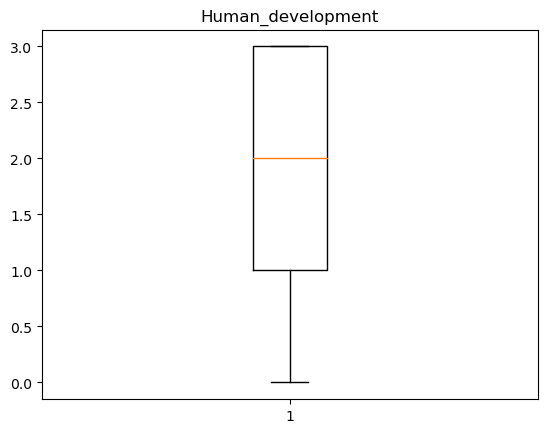

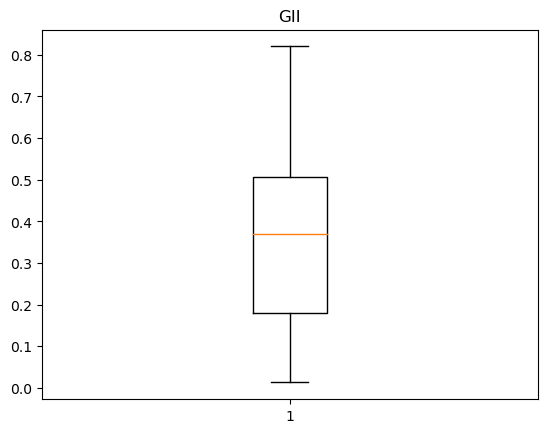

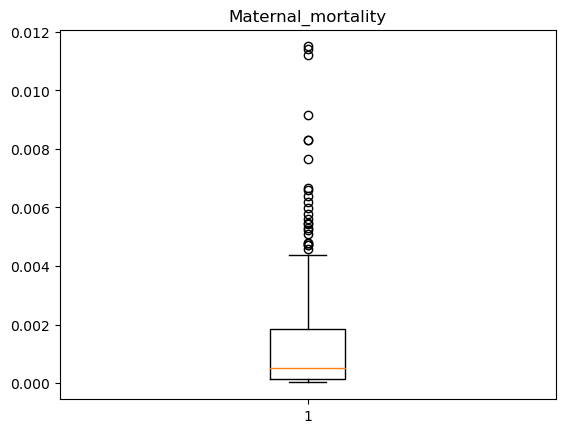

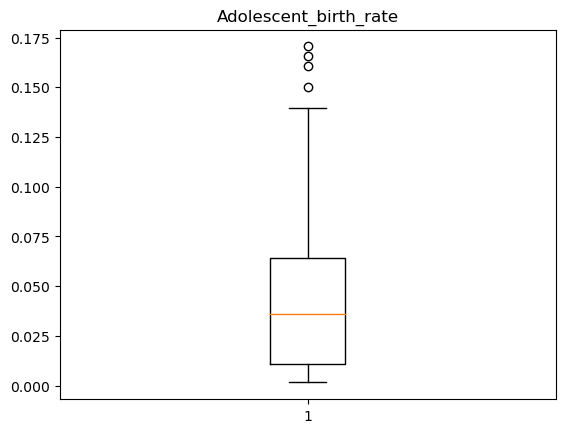

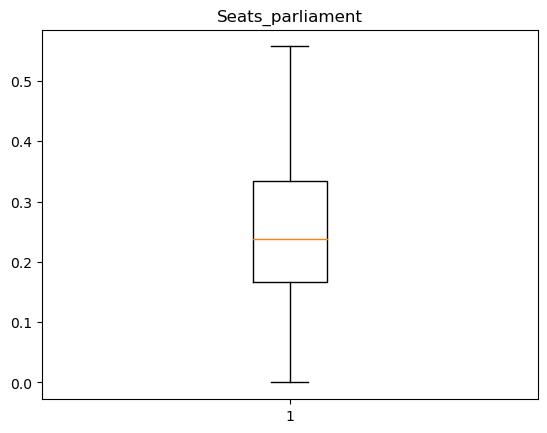

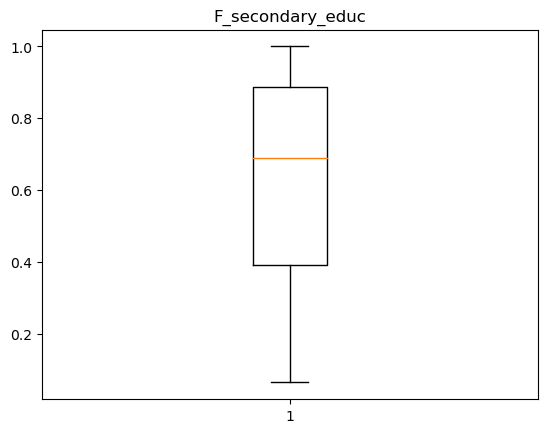

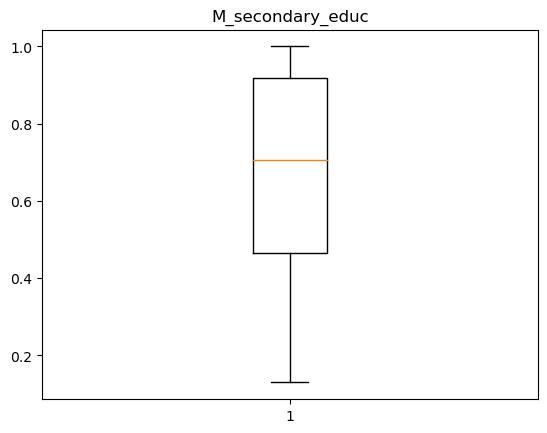

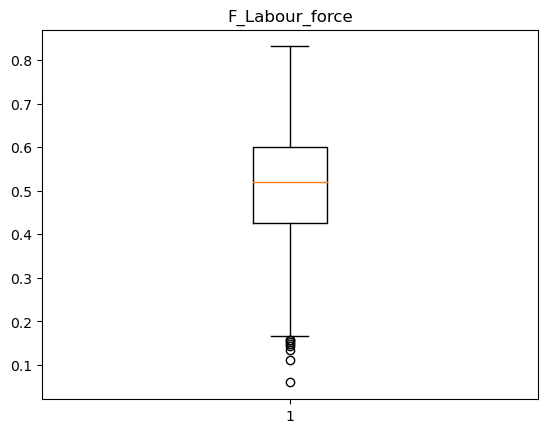

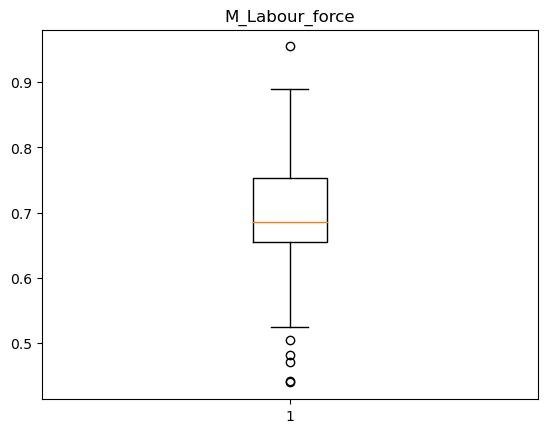

In [10]:
for i in df_imp.columns:
    if df_imp[i].dtype != 'float64':
        pass
    else:
        plt.figure()
        plt.title(i)
        plt.boxplot(df_imp[i].values)
        plt.show()

In [11]:
y_cat = df_imp['Human_development'].replace({0:'Low', 1:'Medium', 2:'High', 3:'Very high'})

<AxesSubplot:>

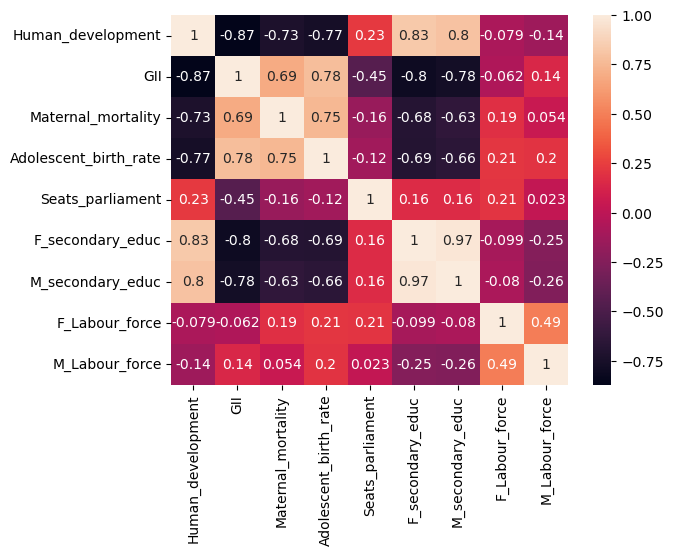

In [12]:
sns.heatmap(df_imp.corr(), annot = True)

In [13]:
df_imp.corr().loc['GII']

Human_development       -0.870776
GII                      1.000000
Maternal_mortality       0.687328
Adolescent_birth_rate    0.775444
Seats_parliament        -0.452850
F_secondary_educ        -0.798215
M_secondary_educ        -0.775520
F_Labour_force          -0.062265
M_Labour_force           0.143130
Name: GII, dtype: float64

From this correlation output we see that the best predictors of GII are human development, adolescent birth rate, female and male secondary education, and maternal mortality.

In [14]:
model = sm.OLS.from_formula('GII ~ Human_development + Adolescent_birth_rate +  F_secondary_educ + F_Labour_force + Seats_parliament', data = df_imp)
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    GII   R-squared:                       0.893
Model:                            OLS   Adj. R-squared:                  0.890
Method:                 Least Squares   F-statistic:                     316.3
Date:                Sat, 08 Apr 2023   Prob (F-statistic):           9.03e-90
Time:                        19:51:37   Log-Likelihood:                 262.39
No. Observations:                 195   AIC:                            -512.8
Df Residuals:                     189   BIC:                            -493.1
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 0.6799      0.025     27.215      0.000       0.631       0.729
Human_development        -0.0691      0.009     -7.957      0.000      -0.086      -0.052
Adolescent_birth_rate     1.5708      0.194      8.089      0.000       1.188       1.954
F_secondary_educ         -0.1541      0.028     -5.412      0.000      -0.210      -0.098
F_Labour_force           -0.1611      0.032     -5.108      0.000      -0.223      -0.099
Seats_parliament         -0.4096      0.039    -10.413      0.000      -0.487      -0.332
==============================================================================
Omnibus:                       11.514   Durbin-Watson:                   1.580
Prob(Omnibus):                  0.003   Jarque-Bera (JB):               13.204
Skew:                           0.468   Prob(JB):                      0.00136
Kurtosis:                       3.866   Cond. No.                         102.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

When looking at our output from the linear model we see that the chosen variables explain 88% of the variation within the data and all of the p values are low. Maternal mortality was removed due to high correlation with the adolescent birth rate which caused the model to have a high condition number. This variable was removed instead of adolescent birth rate because a higher R2 was achieved in this case.

In [15]:
y = df_imp.GII.values
X = df_imp[['Human_development', 'Adolescent_birth_rate',  'F_secondary_educ', 'F_Labour_force', 'Seats_parliament','Maternal_mortality', 'M_secondary_educ','M_Labour_force']].values

In [16]:
transformer = RobustScaler().fit(X)
Fit_X = transformer.transform(X)

robust scaler used rather than the standard scaler because we do have some outliers that make sense in the data that we want to conserve as high values

In [17]:
model = LinearRegression()
kf = KFold(n_splits=5, shuffle=True, random_state=0)

# iterate over the folds and train/validate the model
for train_index, test_index in kf.split(Fit_X):
    score_lis = []
    X_train, X_test = Fit_X[train_index], Fit_X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    model.fit(X_train, y_train)
    score = model.score(X_test, y_test)
    score_lis.append(score)
    print(f'Score: {score}')
print(f'Average Score: {np.mean(score_lis)}')
    

Score: 0.8950510898833708
Score: 0.8255809040064747
Score: 0.9048305154272389
Score: 0.9237318372678189
Score: 0.8684584729699591
Average Score: 0.8684584729699591


In this case adding in the other variables helps in our prediction of the GII score due to their small contribution to the explanation of variation.
K-Fold Cross used to conserve data for training and testing groups and get a better feel for how the fitted model would perform when given new data.

# Predicting categorical values- Human Developement 

In [18]:
df_imp.head()

,Country,Human_development,GII,Maternal_mortality,Adolescent_birth_rate,Seats_parliament,F_secondary_educ,M_secondary_educ,F_Labour_force,M_Labour_force
0,Switzerland,3.0,0.0180,0.000050,0.0022,0.3980,0.969,0.975,0.617,0.727
1,Norway,3.0,0.0160,0.000020,0.0023,0.4500,0.991,0.993,0.603,0.720
2,Iceland,3.0,0.0430,0.000040,0.0054,0.4760,0.998,0.997,0.617,0.705
3,Hong Kong,3.0,0.1234,0.000074,0.0016,0.3024,0.771,0.834,0.535,0.658
4,Australia,3.0,0.0730,0.000060,0.0081,0.3790,0.946,0.944,0.611,0.705


In [19]:
df_imp.Human_development = df_imp.Human_development.astype(int)

[Text(0.6666666666666666, 0.875, 'X[0] <= 0.45\ngini = 0.736\nsamples = 195\nvalue = [34, 45, 50, 66]'),
 Text(0.5, 0.625, 'X[0] <= -0.15\ngini = 0.659\nsamples = 129\nvalue = [34, 45, 50, 0]'),
 Text(0.3333333333333333, 0.375, 'X[0] <= -0.55\ngini = 0.49\nsamples = 79\nvalue = [34, 45, 0, 0]'),
 Text(0.16666666666666666, 0.125, 'gini = 0.0\nsamples = 34\nvalue = [34, 0, 0, 0]'),
 Text(0.5, 0.125, 'gini = 0.0\nsamples = 45\nvalue = [0, 45, 0, 0]'),
 Text(0.6666666666666666, 0.375, 'gini = 0.0\nsamples = 50\nvalue = [0, 0, 50, 0]'),
 Text(0.8333333333333334, 0.625, 'gini = 0.0\nsamples = 66\nvalue = [0, 0, 0, 66]')]

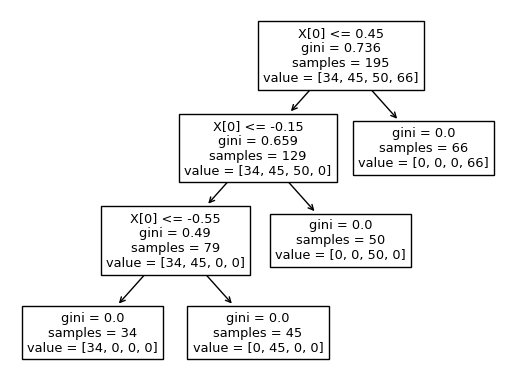

In [20]:
Tree = tree.DecisionTreeClassifier()
X = Fit_X
y = df_imp.loc[:,'Human_development']
model = Tree.fit(X,y)
tree.plot_tree(model)

From this initial tree we see each tree has a 0.0 gini value meaning that the leaf is pure and contains only the values associated with that categorization 

In [24]:
TreeSplit = tree.DecisionTreeClassifier()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
TreeSplit.fit(X_train,y_train)
pred = TreeSplit.predict(X_test)
print(f'Score of model: {r2_score(y_test,pred)}')

Score of model: 1.0


Our model scores a 1.0 meaning that all categories were sorted correctly with no confusion.

# Data Visuzalization

In [22]:
fig = go.Figure(data=go.Choropleth(
    locations = df_imp['Country'],
    locationmode = 'country names',
    z = df_imp['Human_development'],
    text = df_imp['Country'],
    colorscale = 'Greens',
    autocolorscale=False,
    reversescale=False,
    marker_line_color='darkgray',
    marker_line_width=0.5,
    colorbar_title = 'Human Development',
))

fig.update_layout(
    title_text='Human Development',
    geo=dict(
        showframe=False,
        showcoastlines=False,
        projection_type='equirectangular'
    )
)

fig.show()

In [23]:
fig = go.Figure(data=go.Choropleth(
    locations = df_imp['Country'],
    locationmode = 'country names',
    z = df_imp['GII'],
    text = df_imp['Country'],
    colorscale = 'Greens',
    autocolorscale=False,
    reversescale=False,
    marker_line_color='darkgray',
    marker_line_width=0.5,
    colorbar_title = 'Gender Inequality Index',
))

fig.update_layout(
    title_text='Gender Inequality Index',
    geo=dict(
        showframe=False,
        showcoastlines=False,
        projection_type='equirectangular'
    )
)

fig.show()